In [1]:
import pandas as pd
from tokenize_dataset import tokenize_dataset
from isolation_forest import isolation_forest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Set target variable

In [2]:
target = 'overall_survival'

In [3]:
df = pd.read_csv("METABRIC_RNA_Mutation.csv", low_memory=False)

In [4]:
clinical_ids = df[list(df.columns)[0]]

Set patient IDs as the index of df

In [5]:
df = df.set_index(str(list(df.columns)[0]))

In [6]:
df = tokenize_dataset(df)

Partition data

In [7]:
x = df.drop(target, axis=1)
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=84)

X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=84)
y_test, y_val = train_test_split(y_test, test_size=0.5, random_state=84)

Normalize Data

In [9]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)
X_val = min_max_scaler.fit_transform(X_val)

Use Isolation Forest to detect and remove outliers

isolation forest starting
isolation foreset ending
Num Outliers: 138


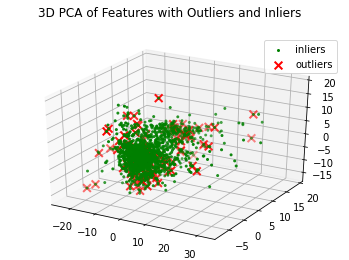

In [10]:
predicted = isolation_forest(X_train, y_train)
non_outlier_indices = []
i = 0
for prediction in predicted:
  if prediction != -1:
    non_outlier_indices.append(i)
  i = i + 1

num_outliers = len(predicted) - len(non_outlier_indices)
print("Num Outliers:", num_outliers)

X_train = X_train[non_outlier_indices]
y_train = y_train.iloc[non_outlier_indices]

Define model

In [11]:
import torch.nn as nn

class metabric_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(691, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)

        return x

In [12]:
num_classes = len(list(set(y_train)))
model = metabric_model(num_classes)

In [13]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def train_model(config, data, epochs=10, batch_size=32):
  X_train = data[0]
  y_train = data[1]
  X_val = data[2]
  y_val = data[3]
  y_train = y_train.to_numpy()
  y_val = y_val.to_numpy()
  X_val = torch.from_numpy(X_val).type(torch.float)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    running_loss = 0.0
    for i in range((X_train.shape[0]-1)//batch_size + 1):
      start_i = i*batch_size
      end_i = start_i+batch_size
      xb = torch.from_numpy(X_train[start_i:end_i]).type(torch.float)
      yb = torch.from_numpy(y_train[start_i:end_i])
      
      pred = model(xb)
      loss = criterion(pred, yb)

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      running_loss += loss.item()
      pred = model(X_val).detach().numpy().astype(np.float)
      pred = np.argmax(pred, axis=1)
      accuracy = accuracy_score(y_val, pred)
      f1 = f1_score(y_val, pred, average='micro')
      print('Completed training batch', epoch, 'Training Loss is: %.4f' %running_loss, 'Accuracy: %.4f' %accuracy, 'F1: %.4f' %f1)
      tune.report(loss=running_loss, accuracy=accuracy)
      running_loss = 0.0

  return model

Use Raytune to determine hyperparameters

In [14]:
import ray
from ray import tune
from ray.tune.schedulers.async_hyperband import ASHAScheduler

config = {
    'epochs':tune.choice([50, 100, 150]),
    'batch_size':tune.choice([8, 16, 32, 64]),
    'lr':tune.loguniform(1e-3, 1e-1),
}
scheduler = ASHAScheduler(
    max_t=10,
    grace_period=1,
    reduction_factor=3
)
result = tune.run(
    tune.with_parameters(train_model, data=[X_train, y_train, X_val, y_val]),
    resources_per_trial={"cpu":2},
    config=config,
    metric="loss",
    mode="min",
    num_samples=10,
    scheduler=scheduler
)
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result['accuracy']))

2022-06-30 04:11:26,102	WARNING function_runner.py:604 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-06-30 04:11:26,201	INFO logger.py:630 -- pip install "ray[tune]" to see TensorBoard files.
2022-06-30 04:11:26,204	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,batch_size,epochs,lr
train_model_b5ad7_00000,RUNNING,172.28.0.2:5298,32,150,0.0055462
train_model_b5ad7_00001,PENDING,,8,150,0.00348766
train_model_b5ad7_00002,PENDING,,32,100,0.00259563
train_model_b5ad7_00003,PENDING,,32,50,0.00343689
train_model_b5ad7_00004,PENDING,,32,150,0.037384
train_model_b5ad7_00005,PENDING,,32,150,0.009287
train_model_b5ad7_00006,PENDING,,32,150,0.0501986
train_model_b5ad7_00007,PENDING,,8,100,0.0359701
train_model_b5ad7_00008,PENDING,,8,150,0.0101537
train_model_b5ad7_00009,PENDING,,32,100,0.00386093


(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
(train_model pid=5298)   import ray._private.utils
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://n

Result for train_model_b5ad7_00000:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-30
  done: false
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 1
  loss: 0.7003059983253479
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.07105255126953125
  time_this_iter_s: 0.07105255126953125
  time_total_s: 0.07105255126953125
  timestamp: 1656562290
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b5ad7_00000
  warmup_time: 0.0050160884857177734
  
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.7003 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6924 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6989 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6855 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Trai

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Result for train_model_b5ad7_00000:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-30
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.6361603736877441
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.2886319160461426
  time_this_iter_s: 0.02749013900756836
  time_total_s: 0.2886319160461426
  timestamp: 1656562290
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b5ad7_00000
  warmup_time: 0.0050160884857177734
  
Result for train_model_b5ad7_00001:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-30
  done: false
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 1
  loss: 0.7000074982643127
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.03185844421386719
  time_this_iter_s: 0.03185844421386719
  time_total_s: 0.03185844421386719
  timestamp: 1656562290
  timesteps_since_restore: 0
  training_iteration:

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Result for train_model_b5ad7_00001:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-30
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.6397329568862915
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.23908233642578125
  time_this_iter_s: 0.020182132720947266
  time_total_s: 0.23908233642578125
  timestamp: 1656562290
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b5ad7_00001
  warmup_time: 0.0050160884857177734
  
Result for train_model_b5ad7_00002:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-30
  done: false
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 1
  loss: 0.6989436149597168
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.020523786544799805
  time_this_iter_s: 0.020523786544799805
  time_total_s: 0.020523786544799805
  timestamp: 1656562290
  timesteps_since_restore: 0
  training_iter

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Result for train_model_b5ad7_00002:(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6856 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6720 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6905 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6649 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6847 Accuracy: 0.5497 F1: 0.5497

  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-30
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.6478003859519958
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.24332523345947266
  time_this_iter_s: 0.022919416427612305
  time_total_s: 0.24332523345947266
  timestamp: 1656562290
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6864 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6845 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6792 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6867 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6613 Accuracy: 0.5497 F1: 0.5497
Result for train_model_b5ad7_00003:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-31
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.634846568107605
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.2304973602294922
  time_this_iter_s: 0.025090932846069336
  time_total_s: 0.2304973602294922
  timestamp: 1656562291
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b5ad

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6945 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6817 Accuracy: 0.6335 F1: 0.6335
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6845 Accuracy: 0.4764 F1: 0.4764
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6875 Accuracy: 0.4921 F1: 0.4921
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6816 Accuracy: 0.6806 F1: 0.6806
Result for train_model_b5ad7_00005:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-31
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.6295953392982483
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.2428443431854248
  time_this_iter_s: 0.024268150329589844
  time_total_s: 0.2428443431854248
  timestamp: 1656562291
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b5a

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=5298) Completed training batch 0 Training Loss is: 0.7005 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6827 Accuracy: 0.6859 F1: 0.6859
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6684 Accuracy: 0.5288 F1: 0.5288
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6692 Accuracy: 0.4974 F1: 0.4974
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6761 Accuracy: 0.6178 F1: 0.6178
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6539 Accuracy: 0.6492 F1: 0.6492
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6488 Accuracy: 0.5497 F1: 0.5497
Result for train_model_b5ad7_00007:
  accuracy: 0.5497382198952879
  date: 2022-06-30_04-11-31
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 9
  loss: 0.6847597360610962
  node_ip: 172.28.0.2
  pid: 5298
  tim

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Trial name,status,loc,batch_size,epochs,lr,iter,total time (s),loss,accuracy
train_model_b5ad7_00008,PENDING,,8,150,0.0101537,,,,
train_model_b5ad7_00009,PENDING,,32,100,0.00386093,,,,
train_model_b5ad7_00000,TERMINATED,172.28.0.2:5298,32,150,0.0055462,10,0.288632,0.63616,0.549738
train_model_b5ad7_00001,TERMINATED,172.28.0.2:5298,8,150,0.00348766,10,0.239082,0.639733,0.549738
train_model_b5ad7_00002,TERMINATED,172.28.0.2:5298,32,100,0.00259563,10,0.243325,0.6478,0.549738
train_model_b5ad7_00003,TERMINATED,172.28.0.2:5298,32,50,0.00343689,10,0.230497,0.634847,0.549738
train_model_b5ad7_00004,TERMINATED,172.28.0.2:5298,32,150,0.037384,1,0.0250039,0.69931,0.549738
train_model_b5ad7_00005,TERMINATED,172.28.0.2:5298,32,150,0.009287,10,0.242844,0.629595,0.549738
train_model_b5ad7_00006,TERMINATED,172.28.0.2:5298,32,150,0.0501986,1,0.0217121,0.700485,0.549738
train_model_b5ad7_00007,TERMINATED,172.28.0.2:5298,8,100,0.0359701,9,0.227115,0.68476,0.549738


(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6858 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6520 Accuracy: 0.5497 F1: 0.5497
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6848 Accuracy: 0.5497 F1: 0.5497
Result for train_model_b5ad7_00008:
  accuracy: 0.6544502617801047
  date: 2022-06-30_04-11-31
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746061450
  iterations_since_restore: 1
  loss: 0.7018162608146667
  node_ip: 172.28.0.2
  pid: 5298
  time_since_restore: 0.029001712799072266
  time_this_iter_s: 0.029001712799072266
  time_total_s: 0.029001712799072266
  timestamp: 1656562291
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b5ad7_00008
  warmup_time: 0.0050160884857177734
  
Result for train_model_b5ad7_00009:
  accuracy: 0.47643979057591623
  date: 2022-06-30_04-11-31
  done: false
  experiment_id: 8e0a0f252425404ea0c54dea01e6

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6298 Accuracy: 0.4607 F1: 0.4607
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6449 Accuracy: 0.4660 F1: 0.4660
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6623 Accuracy: 0.6440 F1: 0.6440
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.5988 Accuracy: 0.6859 F1: 0.6859
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6337 Accuracy: 0.6387 F1: 0.6387
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6582 Accuracy: 0.6440 F1: 0.6440
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6036 Accuracy: 0.7016 F1: 0.7016
(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6138 Accuracy: 0.6859 F1: 0.6859
Result for train_model_b5ad7_00009:
  accuracy: 0.6492146596858639
  date: 2022-06-30_04-11-32
  done: true
  experiment_id: 8e0a0f252425404ea0c54dea01e64de3
  hostname: 71b746

(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Trial name,status,loc,batch_size,epochs,lr,iter,total time (s),loss,accuracy
train_model_b5ad7_00000,TERMINATED,172.28.0.2:5298,32,150,0.0055462,10,0.288632,0.63616,0.549738
train_model_b5ad7_00001,TERMINATED,172.28.0.2:5298,8,150,0.00348766,10,0.239082,0.639733,0.549738
train_model_b5ad7_00002,TERMINATED,172.28.0.2:5298,32,100,0.00259563,10,0.243325,0.6478,0.549738
train_model_b5ad7_00003,TERMINATED,172.28.0.2:5298,32,50,0.00343689,10,0.230497,0.634847,0.549738
train_model_b5ad7_00004,TERMINATED,172.28.0.2:5298,32,150,0.037384,1,0.0250039,0.69931,0.549738
train_model_b5ad7_00005,TERMINATED,172.28.0.2:5298,32,150,0.009287,10,0.242844,0.629595,0.549738
train_model_b5ad7_00006,TERMINATED,172.28.0.2:5298,32,150,0.0501986,1,0.0217121,0.700485,0.549738
train_model_b5ad7_00007,TERMINATED,172.28.0.2:5298,8,100,0.0359701,9,0.227115,0.68476,0.549738
train_model_b5ad7_00008,TERMINATED,172.28.0.2:5298,8,150,0.0101537,1,0.0290017,0.701816,0.65445
train_model_b5ad7_00009,TERMINATED,172.28.0.2:5298,32,100,0.00386093,10,0.288048,0.615877,0.649215


(train_model pid=5298) Completed training batch 0 Training Loss is: 0.6159 Accuracy: 0.6492 F1: 0.6492


(train_model pid=5298) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=5298) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=5298)   )
2022-06-30 04:11:32,371	INFO tune.py:748 -- Total run time: 6.27 seconds (5.90 seconds for the tuning loop).


Best trial config: {'epochs': 100, 'batch_size': 32, 'lr': 0.003860930717715257}
Best trial final validation loss: 0.6158774495124817
Best trial final validation accuracy: 0.6492146596858639


In [15]:
train_model(config=best_trial, data=[X_train, y_train, X_val, y_val])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 0 Training Loss is: 0.7003 Accuracy: 0.5497 F1: 0.5497


2022-06-30 04:11:32,917	WARNING session.py:35 -- Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
2022-06-30 04:11:32,921	WARNING session.py:38 --   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib

Completed training batch 0 Training Loss is: 0.6924 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6989 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6855 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6855 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6685 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6916 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6598 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6853 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6362 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6853 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.7155 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6853 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6853 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6776 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6389 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.7170 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6692 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.7014 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6688 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.7018 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6686 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6685 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6597 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.7025 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.7027 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6591 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6941 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.7204 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6765 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6507 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6937 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.7023 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.7022 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.7019 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6767 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6602 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.7008 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.7000 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6770 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6547 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6374 Accuracy: 0.5497 F1: 0.5497
Completed training batch 0 Training Loss is: 0.6335 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6232 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7039 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6949 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.7046 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6856 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6856 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6570 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6953 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6468 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6856 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6150 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6856 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.7287 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6860 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6861 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6750 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6196 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7317 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6634 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7091 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6630 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.7096 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6631 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6632 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6516 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7093 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7095 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6514 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6978 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7312 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6745 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6416 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6961 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.7067 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7065 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7059 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6749 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6544 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.7050 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.7048 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6751 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6459 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6261 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6255 Accuracy: 0.5497 F1: 0.5497
Completed training batch 1 Training Loss is: 0.6151 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.7054 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6958 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.7065 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6848 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6841 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6520 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6960 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6373 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6832 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.5985 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6827 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.7374 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6845 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6838 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6697 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6021 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.7394 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6550 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.7070 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6518 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.7075 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6534 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6548 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6378 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6981 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.7029 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6319 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6872 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.7174 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6504 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6185 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6612 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6730 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.6741 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6496 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6192 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.5704 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6449 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.6523 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.5672 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.5636 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.4966 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.4356 Accuracy: 0.5497 F1: 0.5497
Completed training batch 2 Training Loss is: 0.3442 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.9356 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.8620 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.5919 Accuracy: 0.7853 F1: 0.7853
Completed training batch 3 Training Loss is: 0.6544 Accuracy: 0.5236 F1: 0.5236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.6662 Accuracy: 0.5026 F1: 0.5026
Completed training batch 3 Training Loss is: 0.6993 Accuracy: 0.5026 F1: 0.5026
Completed training batch 3 Training Loss is: 0.6768 Accuracy: 0.4974 F1: 0.4974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.6945 Accuracy: 0.5183 F1: 0.5183
Completed training batch 3 Training Loss is: 0.6807 Accuracy: 0.7120 F1: 0.7120
Completed training batch 3 Training Loss is: 0.6611 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.6623 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.6822 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.6668 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.6298 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.6174 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.5317 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.7485 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.6081 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.7057 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.5846 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.7240 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.5854 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.5870 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.5363 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.6072 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.6237 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.5516 Accuracy: 0.5497 F1: 0.5497
Completed training batch 3 Training Loss is: 0.6067 Accuracy: 0.5497 F1: 0.5497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.6202 Accuracy: 0.5707 F1: 0.5707
Completed training batch 3 Training Loss is: 0.5266 Accuracy: 0.6283 F1: 0.6283
Completed training batch 3 Training Loss is: 0.4858 Accuracy: 0.6440 F1: 0.6440


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.5390 Accuracy: 0.6754 F1: 0.6754
Completed training batch 3 Training Loss is: 0.5458 Accuracy: 0.7016 F1: 0.7016
Completed training batch 3 Training Loss is: 0.5442 Accuracy: 0.7330 F1: 0.7330


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.4491 Accuracy: 0.7592 F1: 0.7592
Completed training batch 3 Training Loss is: 0.4775 Accuracy: 0.7644 F1: 0.7644
Completed training batch 3 Training Loss is: 0.4197 Accuracy: 0.7068 F1: 0.7068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.4128 Accuracy: 0.7016 F1: 0.7016
Completed training batch 3 Training Loss is: 0.4228 Accuracy: 0.7906 F1: 0.7906
Completed training batch 3 Training Loss is: 0.3830 Accuracy: 0.7853 F1: 0.7853


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.5305 Accuracy: 0.7435 F1: 0.7435
Completed training batch 3 Training Loss is: 0.2515 Accuracy: 0.6649 F1: 0.6649
Completed training batch 3 Training Loss is: 0.3313 Accuracy: 0.5864 F1: 0.5864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.3364 Accuracy: 0.5864 F1: 0.5864
Completed training batch 4 Training Loss is: 0.9329 Accuracy: 0.6911 F1: 0.6911
Completed training batch 4 Training Loss is: 0.6585 Accuracy: 0.7487 F1: 0.7487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3392 Accuracy: 0.6387 F1: 0.6387
Completed training batch 4 Training Loss is: 0.7064 Accuracy: 0.6911 F1: 0.6911
Completed training batch 4 Training Loss is: 0.4363 Accuracy: 0.7906 F1: 0.7906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.4081 Accuracy: 0.6911 F1: 0.6911
Completed training batch 4 Training Loss is: 0.4165 Accuracy: 0.6440 F1: 0.6440
Completed training batch 4 Training Loss is: 0.2626 Accuracy: 0.6178 F1: 0.6178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.4289 Accuracy: 0.6387 F1: 0.6387
Completed training batch 4 Training Loss is: 0.3384 Accuracy: 0.6911 F1: 0.6911
Completed training batch 4 Training Loss is: 0.2937 Accuracy: 0.7644 F1: 0.7644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3026 Accuracy: 0.8115 F1: 0.8115
Completed training batch 4 Training Loss is: 0.3990 Accuracy: 0.7801 F1: 0.7801
Completed training batch 4 Training Loss is: 0.3112 Accuracy: 0.7958 F1: 0.7958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.5324 Accuracy: 0.7958 F1: 0.7958
Completed training batch 4 Training Loss is: 0.3421 Accuracy: 0.7592 F1: 0.7592
Completed training batch 4 Training Loss is: 0.3751 Accuracy: 0.7330 F1: 0.7330


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.2923 Accuracy: 0.7068 F1: 0.7068
Completed training batch 4 Training Loss is: 0.3946 Accuracy: 0.7330 F1: 0.7330
Completed training batch 4 Training Loss is: 0.2103 Accuracy: 0.7592 F1: 0.7592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.4852 Accuracy: 0.7696 F1: 0.7696
Completed training batch 4 Training Loss is: 0.2783 Accuracy: 0.7853 F1: 0.7853
Completed training batch 4 Training Loss is: 0.3753 Accuracy: 0.7801 F1: 0.7801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.1910 Accuracy: 0.7801 F1: 0.7801
Completed training batch 4 Training Loss is: 0.2075 Accuracy: 0.7801 F1: 0.7801
Completed training batch 4 Training Loss is: 0.2353 Accuracy: 0.7906 F1: 0.7906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.1547 Accuracy: 0.7801 F1: 0.7801
Completed training batch 4 Training Loss is: 0.3389 Accuracy: 0.7853 F1: 0.7853
Completed training batch 4 Training Loss is: 0.1912 Accuracy: 0.8220 F1: 0.8220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.1544 Accuracy: 0.8325 F1: 0.8325
Completed training batch 4 Training Loss is: 0.1554 Accuracy: 0.7644 F1: 0.7644
Completed training batch 4 Training Loss is: 0.1473 Accuracy: 0.6911 F1: 0.6911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.2944 Accuracy: 0.6754 F1: 0.6754
Completed training batch 4 Training Loss is: 0.4045 Accuracy: 0.6911 F1: 0.6911
Completed training batch 4 Training Loss is: 0.1085 Accuracy: 0.7958 F1: 0.7958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.1682 Accuracy: 0.8377 F1: 0.8377
Completed training batch 4 Training Loss is: 0.1565 Accuracy: 0.7644 F1: 0.7644
Completed training batch 4 Training Loss is: 0.0851 Accuracy: 0.6963 F1: 0.6963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.2217 Accuracy: 0.6963 F1: 0.6963
Completed training batch 4 Training Loss is: 0.3865 Accuracy: 0.7382 F1: 0.7382
Completed training batch 4 Training Loss is: 0.3263 Accuracy: 0.7958 F1: 0.7958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.0536 Accuracy: 0.8377 F1: 0.8377
Completed training batch 4 Training Loss is: 0.3852 Accuracy: 0.7853 F1: 0.7853
Completed training batch 4 Training Loss is: 0.0586 Accuracy: 0.7016 F1: 0.7016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2811 Accuracy: 0.6387 F1: 0.6387
Completed training batch 5 Training Loss is: 0.5873 Accuracy: 0.6963 F1: 0.6963
Completed training batch 5 Training Loss is: 0.2990 Accuracy: 0.8063 F1: 0.8063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0893 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.1361 Accuracy: 0.8272 F1: 0.8272
Completed training batch 5 Training Loss is: 0.4952 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1145 Accuracy: 0.7173 F1: 0.7173
Completed training batch 5 Training Loss is: 0.0546 Accuracy: 0.6126 F1: 0.6126
Completed training batch 5 Training Loss is: 0.1558 Accuracy: 0.5812 F1: 0.5812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.3249 Accuracy: 0.6178 F1: 0.6178
Completed training batch 5 Training Loss is: 0.2408 Accuracy: 0.7330 F1: 0.7330
Completed training batch 5 Training Loss is: 0.1769 Accuracy: 0.8377 F1: 0.8377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1143 Accuracy: 0.8901 F1: 0.8901
Completed training batch 5 Training Loss is: 0.0927 Accuracy: 0.8534 F1: 0.8534
Completed training batch 5 Training Loss is: 0.5259 Accuracy: 0.8534 F1: 0.8534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2463 Accuracy: 0.7435 F1: 0.7435
Completed training batch 5 Training Loss is: 0.1373 Accuracy: 0.6702 F1: 0.6702
Completed training batch 5 Training Loss is: 0.1462 Accuracy: 0.6283 F1: 0.6283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2714 Accuracy: 0.6859 F1: 0.6859
Completed training batch 5 Training Loss is: 0.1287 Accuracy: 0.7487 F1: 0.7487
Completed training batch 5 Training Loss is: 0.2367 Accuracy: 0.8272 F1: 0.8272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0752 Accuracy: 0.8743 F1: 0.8743
Completed training batch 5 Training Loss is: 0.3372 Accuracy: 0.8429 F1: 0.8429
Completed training batch 5 Training Loss is: 0.0719 Accuracy: 0.8010 F1: 0.8010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0624 Accuracy: 0.7539 F1: 0.7539
Completed training batch 5 Training Loss is: 0.0734 Accuracy: 0.7120 F1: 0.7120
Completed training batch 5 Training Loss is: 0.0437 Accuracy: 0.6859 F1: 0.6859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2230 Accuracy: 0.7016 F1: 0.7016
Completed training batch 5 Training Loss is: 0.1403 Accuracy: 0.7592 F1: 0.7592
Completed training batch 5 Training Loss is: 0.0531 Accuracy: 0.8482 F1: 0.8482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0448 Accuracy: 0.8848 F1: 0.8848
Completed training batch 5 Training Loss is: 0.0739 Accuracy: 0.9005 F1: 0.9005
Completed training batch 5 Training Loss is: 0.2303 Accuracy: 0.8168 F1: 0.8168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1276 Accuracy: 0.7592 F1: 0.7592
Completed training batch 5 Training Loss is: 0.0342 Accuracy: 0.7016 F1: 0.7016
Completed training batch 5 Training Loss is: 0.0514 Accuracy: 0.6806 F1: 0.6806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0834 Accuracy: 0.6859 F1: 0.6859
Completed training batch 5 Training Loss is: 0.0370 Accuracy: 0.7225 F1: 0.7225
Completed training batch 5 Training Loss is: 0.0560 Accuracy: 0.7644 F1: 0.7644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2445 Accuracy: 0.8063 F1: 0.8063
Completed training batch 5 Training Loss is: 0.1540 Accuracy: 0.7696 F1: 0.7696
Completed training batch 5 Training Loss is: 0.0135 Accuracy: 0.7592 F1: 0.7592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0515 Accuracy: 0.7173 F1: 0.7173
Completed training batch 5 Training Loss is: 0.0075 Accuracy: 0.6702 F1: 0.6702
Completed training batch 6 Training Loss is: 0.1319 Accuracy: 0.6283 F1: 0.6283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.3102 Accuracy: 0.7173 F1: 0.7173
Completed training batch 6 Training Loss is: 0.1385 Accuracy: 0.8220 F1: 0.8220
Completed training batch 6 Training Loss is: 0.0281 Accuracy: 0.9110 F1: 0.9110


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.0255 Accuracy: 0.8796 F1: 0.8796
Completed training batch 6 Training Loss is: 0.5485 Accuracy: 0.8586 F1: 0.8586
Completed training batch 6 Training Loss is: 0.0811 Accuracy: 0.7068 F1: 0.7068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.0100 Accuracy: 0.5602 F1: 0.5602
Completed training batch 6 Training Loss is: 0.0487 Accuracy: 0.5602 F1: 0.5602
Completed training batch 6 Training Loss is: 0.5603 Accuracy: 0.5602 F1: 0.5602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.5536 Accuracy: 0.6545 F1: 0.6545
Completed training batch 6 Training Loss is: 0.1207 Accuracy: 0.8272 F1: 0.8272
Completed training batch 6 Training Loss is: 0.0398 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1293 Accuracy: 0.7696 F1: 0.7696
Completed training batch 6 Training Loss is: 1.1171 Accuracy: 0.8639 F1: 0.8639
Completed training batch 6 Training Loss is: 0.5833 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.0476 Accuracy: 0.7225 F1: 0.7225
Completed training batch 6 Training Loss is: 0.0379 Accuracy: 0.5707 F1: 0.5707
Completed training batch 6 Training Loss is: 0.2004 Accuracy: 0.5602 F1: 0.5602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.3230 Accuracy: 0.5602 F1: 0.5602
Completed training batch 6 Training Loss is: 0.5740 Accuracy: 0.6702 F1: 0.6702
Completed training batch 6 Training Loss is: 0.0900 Accuracy: 0.7958 F1: 0.7958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1172 Accuracy: 0.8796 F1: 0.8796
Completed training batch 6 Training Loss is: 0.0836 Accuracy: 0.9110 F1: 0.9110
Completed training batch 6 Training Loss is: 0.1334 Accuracy: 0.8848 F1: 0.8848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2638 Accuracy: 0.8848 F1: 0.8848
Completed training batch 6 Training Loss is: 0.3902 Accuracy: 0.9110 F1: 0.9110
Completed training batch 6 Training Loss is: 0.1672 Accuracy: 0.8534 F1: 0.8534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1004 Accuracy: 0.7749 F1: 0.7749
Completed training batch 6 Training Loss is: 0.0839 Accuracy: 0.6859 F1: 0.6859
Completed training batch 6 Training Loss is: 0.0897 Accuracy: 0.6178 F1: 0.6178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1114 Accuracy: 0.5864 F1: 0.5864
Completed training batch 6 Training Loss is: 0.1831 Accuracy: 0.5864 F1: 0.5864
Completed training batch 6 Training Loss is: 0.2610 Accuracy: 0.6387 F1: 0.6387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1353 Accuracy: 0.7068 F1: 0.7068
Completed training batch 6 Training Loss is: 0.0655 Accuracy: 0.7801 F1: 0.7801
Completed training batch 6 Training Loss is: 0.0408 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.0632 Accuracy: 0.8743 F1: 0.8743
Completed training batch 6 Training Loss is: 0.0595 Accuracy: 0.8901 F1: 0.8901
Completed training batch 6 Training Loss is: 0.2523 Accuracy: 0.8953 F1: 0.8953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1818 Accuracy: 0.8429 F1: 0.8429
Completed training batch 6 Training Loss is: 0.0361 Accuracy: 0.7906 F1: 0.7906
Completed training batch 6 Training Loss is: 0.0557 Accuracy: 0.7330 F1: 0.7330


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.0155 Accuracy: 0.6754 F1: 0.6754
Completed training batch 7 Training Loss is: 0.0721 Accuracy: 0.6178 F1: 0.6178
Completed training batch 7 Training Loss is: 0.2005 Accuracy: 0.6230 F1: 0.6230


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.1828 Accuracy: 0.6911 F1: 0.6911
Completed training batch 7 Training Loss is: 0.0273 Accuracy: 0.7435 F1: 0.7435
Completed training batch 7 Training Loss is: 0.0129 Accuracy: 0.8063 F1: 0.8063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0358 Accuracy: 0.8482 F1: 0.8482
Completed training batch 7 Training Loss is: 0.0449 Accuracy: 0.8743 F1: 0.8743
Completed training batch 7 Training Loss is: 0.0315 Accuracy: 0.9005 F1: 0.9005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.2333 Accuracy: 0.8586 F1: 0.8586
Completed training batch 7 Training Loss is: 0.0172 Accuracy: 0.8325 F1: 0.8325
Completed training batch 7 Training Loss is: 0.0127 Accuracy: 0.8010 F1: 0.8010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0879 Accuracy: 0.7435 F1: 0.7435
Completed training batch 7 Training Loss is: 0.0144 Accuracy: 0.6963 F1: 0.6963
Completed training batch 7 Training Loss is: 0.0095 Accuracy: 0.6754 F1: 0.6754


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0126 Accuracy: 0.6230 F1: 0.6230
Completed training batch 7 Training Loss is: 0.0628 Accuracy: 0.6021 F1: 0.6021
Completed training batch 7 Training Loss is: 0.1710 Accuracy: 0.6754 F1: 0.6754


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0130 Accuracy: 0.7435 F1: 0.7435
Completed training batch 7 Training Loss is: 0.0100 Accuracy: 0.8010 F1: 0.8010
Completed training batch 7 Training Loss is: 0.0234 Accuracy: 0.8272 F1: 0.8272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0841 Accuracy: 0.8639 F1: 0.8639
Completed training batch 7 Training Loss is: 0.0171 Accuracy: 0.9058 F1: 0.9058
Completed training batch 7 Training Loss is: 0.1928 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0112 Accuracy: 0.8272 F1: 0.8272
Completed training batch 7 Training Loss is: 0.0049 Accuracy: 0.8010 F1: 0.8010
Completed training batch 7 Training Loss is: 0.0073 Accuracy: 0.7592 F1: 0.7592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0052 Accuracy: 0.7225 F1: 0.7225
Completed training batch 7 Training Loss is: 0.0456 Accuracy: 0.7225 F1: 0.7225
Completed training batch 7 Training Loss is: 0.0079 Accuracy: 0.7225 F1: 0.7225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0077 Accuracy: 0.7225 F1: 0.7225
Completed training batch 7 Training Loss is: 0.0044 Accuracy: 0.7382 F1: 0.7382
Completed training batch 7 Training Loss is: 0.0038 Accuracy: 0.7435 F1: 0.7435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0086 Accuracy: 0.7592 F1: 0.7592
Completed training batch 7 Training Loss is: 0.0698 Accuracy: 0.7696 F1: 0.7696
Completed training batch 7 Training Loss is: 0.0081 Accuracy: 0.7906 F1: 0.7906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0058 Accuracy: 0.8272 F1: 0.8272
Completed training batch 7 Training Loss is: 0.0029 Accuracy: 0.8325 F1: 0.8325
Completed training batch 7 Training Loss is: 0.0113 Accuracy: 0.8377 F1: 0.8377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0067 Accuracy: 0.8325 F1: 0.8325
Completed training batch 7 Training Loss is: 0.1873 Accuracy: 0.7853 F1: 0.7853
Completed training batch 7 Training Loss is: 0.0196 Accuracy: 0.7173 F1: 0.7173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0037 Accuracy: 0.6702 F1: 0.6702
Completed training batch 7 Training Loss is: 0.0119 Accuracy: 0.6335 F1: 0.6335
Completed training batch 7 Training Loss is: 0.0009 Accuracy: 0.5916 F1: 0.5916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0675 Accuracy: 0.6335 F1: 0.6335
Completed training batch 8 Training Loss is: 0.1257 Accuracy: 0.7068 F1: 0.7068
Completed training batch 8 Training Loss is: 0.0113 Accuracy: 0.8115 F1: 0.8115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0054 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.0039 Accuracy: 0.9162 F1: 0.9162
Completed training batch 8 Training Loss is: 0.0595 Accuracy: 0.9215 F1: 0.9215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1625 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.0062 Accuracy: 0.7853 F1: 0.7853
Completed training batch 8 Training Loss is: 0.0104 Accuracy: 0.6859 F1: 0.6859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0079 Accuracy: 0.6230 F1: 0.6230
Completed training batch 8 Training Loss is: 0.0049 Accuracy: 0.5707 F1: 0.5707
Completed training batch 8 Training Loss is: 0.1361 Accuracy: 0.5916 F1: 0.5916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0530 Accuracy: 0.6806 F1: 0.6806
Completed training batch 8 Training Loss is: 0.0024 Accuracy: 0.7906 F1: 0.7906
Completed training batch 8 Training Loss is: 0.0090 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1489 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.0048 Accuracy: 0.8796 F1: 0.8796
Completed training batch 8 Training Loss is: 0.0307 Accuracy: 0.8482 F1: 0.8482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0090 Accuracy: 0.8220 F1: 0.8220
Completed training batch 8 Training Loss is: 0.0219 Accuracy: 0.7696 F1: 0.7696
Completed training batch 8 Training Loss is: 0.0498 Accuracy: 0.7435 F1: 0.7435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0017 Accuracy: 0.7225 F1: 0.7225
Completed training batch 8 Training Loss is: 0.0055 Accuracy: 0.7016 F1: 0.7016
Completed training batch 8 Training Loss is: 0.0041 Accuracy: 0.7016 F1: 0.7016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0039 Accuracy: 0.6963 F1: 0.6963
Completed training batch 8 Training Loss is: 0.0047 Accuracy: 0.6859 F1: 0.6859
Completed training batch 8 Training Loss is: 0.0017 Accuracy: 0.6754 F1: 0.6754


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0071 Accuracy: 0.6911 F1: 0.6911
Completed training batch 8 Training Loss is: 0.0045 Accuracy: 0.6963 F1: 0.6963
Completed training batch 8 Training Loss is: 0.0036 Accuracy: 0.7016 F1: 0.7016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0020 Accuracy: 0.7016 F1: 0.7016
Completed training batch 8 Training Loss is: 0.0016 Accuracy: 0.7120 F1: 0.7120
Completed training batch 8 Training Loss is: 0.0033 Accuracy: 0.7173 F1: 0.7173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0122 Accuracy: 0.7592 F1: 0.7592
Completed training batch 8 Training Loss is: 0.0038 Accuracy: 0.7906 F1: 0.7906
Completed training batch 8 Training Loss is: 0.0023 Accuracy: 0.8168 F1: 0.8168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0014 Accuracy: 0.8272 F1: 0.8272
Completed training batch 8 Training Loss is: 0.0039 Accuracy: 0.8325 F1: 0.8325
Completed training batch 8 Training Loss is: 0.0031 Accuracy: 0.8534 F1: 0.8534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1188 Accuracy: 0.7906 F1: 0.7906
Completed training batch 8 Training Loss is: 0.0058 Accuracy: 0.7225 F1: 0.7225
Completed training batch 8 Training Loss is: 0.0012 Accuracy: 0.6702 F1: 0.6702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0029 Accuracy: 0.6387 F1: 0.6387
Completed training batch 8 Training Loss is: 0.0005 Accuracy: 0.6073 F1: 0.6073
Completed training batch 9 Training Loss is: 0.0115 Accuracy: 0.6021 F1: 0.6021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0448 Accuracy: 0.6073 F1: 0.6073
Completed training batch 9 Training Loss is: 0.0508 Accuracy: 0.6859 F1: 0.6859
Completed training batch 9 Training Loss is: 0.0014 Accuracy: 0.7801 F1: 0.7801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0007 Accuracy: 0.8429 F1: 0.8429
Completed training batch 9 Training Loss is: 0.0042 Accuracy: 0.8953 F1: 0.8953
Completed training batch 9 Training Loss is: 0.0169 Accuracy: 0.9267 F1: 0.9267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0120 Accuracy: 0.9267 F1: 0.9267
Completed training batch 9 Training Loss is: 0.2146 Accuracy: 0.8429 F1: 0.8429
Completed training batch 9 Training Loss is: 0.0013 Accuracy: 0.7382 F1: 0.7382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0009 Accuracy: 0.6387 F1: 0.6387
Completed training batch 9 Training Loss is: 0.0054 Accuracy: 0.5864 F1: 0.5864
Completed training batch 9 Training Loss is: 0.0143 Accuracy: 0.5602 F1: 0.5602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0536 Accuracy: 0.5654 F1: 0.5654
Completed training batch 9 Training Loss is: 0.0107 Accuracy: 0.5864 F1: 0.5864
Completed training batch 9 Training Loss is: 0.0057 Accuracy: 0.6178 F1: 0.6178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0558 Accuracy: 0.6806 F1: 0.6806
Completed training batch 9 Training Loss is: 0.0023 Accuracy: 0.7539 F1: 0.7539
Completed training batch 9 Training Loss is: 0.0017 Accuracy: 0.8168 F1: 0.8168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0123 Accuracy: 0.8482 F1: 0.8482
Completed training batch 9 Training Loss is: 0.0032 Accuracy: 0.8953 F1: 0.8953
Completed training batch 9 Training Loss is: 0.0043 Accuracy: 0.9005 F1: 0.9005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0397 Accuracy: 0.9005 F1: 0.9005
Completed training batch 9 Training Loss is: 0.0028 Accuracy: 0.8743 F1: 0.8743
Completed training batch 9 Training Loss is: 0.0008 Accuracy: 0.8482 F1: 0.8482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0021 Accuracy: 0.8377 F1: 0.8377
Completed training batch 9 Training Loss is: 0.0023 Accuracy: 0.8115 F1: 0.8115
Completed training batch 9 Training Loss is: 0.0012 Accuracy: 0.7906 F1: 0.7906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0013 Accuracy: 0.7696 F1: 0.7696
Completed training batch 9 Training Loss is: 0.0019 Accuracy: 0.7487 F1: 0.7487
Completed training batch 9 Training Loss is: 0.0005 Accuracy: 0.7277 F1: 0.7277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0007 Accuracy: 0.7120 F1: 0.7120
Completed training batch 9 Training Loss is: 0.0015 Accuracy: 0.7120 F1: 0.7120
Completed training batch 9 Training Loss is: 0.0020 Accuracy: 0.7068 F1: 0.7068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0042 Accuracy: 0.7068 F1: 0.7068
Completed training batch 9 Training Loss is: 0.0010 Accuracy: 0.6963 F1: 0.6963
Completed training batch 9 Training Loss is: 0.0018 Accuracy: 0.6963 F1: 0.6963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0007 Accuracy: 0.6963 F1: 0.6963
Completed training batch 9 Training Loss is: 0.0015 Accuracy: 0.6963 F1: 0.6963
Completed training batch 9 Training Loss is: 0.0041 Accuracy: 0.7016 F1: 0.7016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0058 Accuracy: 0.7120 F1: 0.7120
Completed training batch 9 Training Loss is: 0.0007 Accuracy: 0.7120 F1: 0.7120
Completed training batch 9 Training Loss is: 0.0015 Accuracy: 0.7225 F1: 0.7225
Completed training batch 9 Training Loss is: 0.0004 Accuracy: 0.7277 F1: 0.7277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


metabric_model(
  (relu): ReLU()
  (fc1): Linear(in_features=691, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=2, bias=True)
)

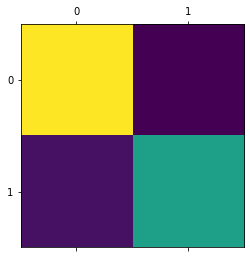

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

X_test = X_test.type(torch.float)
pred = model(X_test).detach().numpy()
pred = np.argmax(pred, axis=1)

plt.matshow(confusion_matrix(y_test, pred))